In [2]:
import pandas as pd
import numpy as np
import re
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

In [3]:
def clean_string(query):
    return re.sub('\s+', ' ', query.replace('(', ' ').replace(')', ' ').replace(',', ' , ')).strip()

In [4]:
df = pd.read_csv('../data/non_obf_data.csv')
df

,payload,length,label
0,c/ caridad s/n,14,0
1,"campello, el",12,0
2,40184,5,0
3,1442431887503330,16,0
4,nue37,5,0
...,...,...,...
30151,"1') and extractvalue(7982,concat(0x5c,0x717170...",111,1
30152,"1"" order by 1--",15,1
30153,"1' procedure analyse(extractvalue(5840,concat(...",149,1
30154,1 rlike (select * from (select(sleep(5)))sgvo)...,53,1


In [5]:
count_vect = CountVectorizer(analyzer='word', ngram_range=(3,3))
raw_counts = count_vect.fit_transform(df['payload'])

# Display features
features = count_vect.get_feature_names()
print('Number of features: ' + str(len(features)))

Number of features: 37275


In [6]:
# Append metadata to sparse matrix that will be used to train the classifier
num_feats = df[['length']].values
all_data = sparse.hstack((raw_counts, num_feats))
all_labels = df['label'].values

In [7]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size=0.3, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
classifier = GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={
                 'n_estimators': [1, 5, 10, 25, 50, 100, 150], 
                 'max_depth': [None, 1, 5, 10, 25],
                 'max_features': ['auto', 1, 5, 10, 25]               
             }
            )
classifier.fit(train_data, train_labels)
classifier = classifier.best_estimator_

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
# Run inference on the test data and predict labels for each data point in the test data
predicted_labels = classifier.predict(test_data)

# Calculate and print the following metrics: precision, recall, f1-measure, and accuracy
from sklearn import metrics
precision = metrics.precision_score(test_labels, predicted_labels)
recall = metrics.recall_score(test_labels, predicted_labels)
f1measure = metrics.f1_score(test_labels, predicted_labels)
accuracy = metrics.accuracy_score(test_labels, predicted_labels)

print(' precision = ' + str(precision))
print('    recall = ' + str(recall))
print('F1-measure = ' + str(f1measure))
print('  accuracy = ' + str(accuracy))
print('\n')

In [22]:
classifier = classifier.best_estimator_
classifier.feature_importances_

array([0.00015259, 0.        , 0.        , ..., 0.        , 0.        ,
       0.01234213])

In [23]:
np.argsort(classifier.feature_importances_)[::-1]

array([32834, 26907, 37275, ..., 24012, 24013, 18637])

In [24]:
np.sort(classifier.feature_importances_)[::-1][0:10]

array([0.01484244, 0.01349513, 0.01234213, 0.01111521, 0.01038812,
       0.01027238, 0.0097625 , 0.0085145 , 0.00838242, 0.00818043])

In [25]:
# features[2551635] -> length

In [26]:
np.argsort(classifier.feature_importances_)[::-1][0:10]

array([32834, 26907, 37275, 21290, 21304,   462,   720, 31930,   715,
       15001])

In [27]:
for i in np.argsort(classifier.feature_importances_)[::-1][0:10]:
    if(i == 37275):
        print('string length')
        continue
    print(features[i])

union all select
null null null
string length
chr 112 chr
chr 113 select
112 chr 106
113 select case
t2 sysibm systables
113 chr 112
all_users t1 all_users


In [28]:
np.sort(classifier.feature_importances_)[::-1][0:10]

array([0.01484244, 0.01349513, 0.01234213, 0.01111521, 0.01038812,
       0.01027238, 0.0097625 , 0.0085145 , 0.00838242, 0.00818043])

['string length', 'union all select', 'select case when', 'select null null', 'select count from', '113 select case', 'all select null', 'from select sleep', 'select from select', 'else end from']


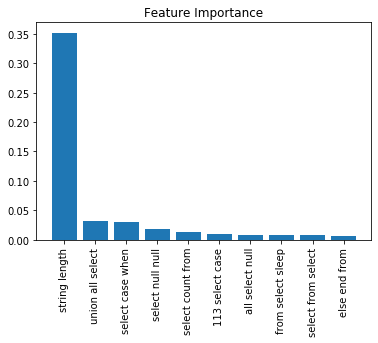

In [30]:
import matplotlib.pyplot as plt
indices = np.argsort(classifier.feature_importances_)[::-1][0:10]
features.append('string length')
names = [features[i] for i in indices]
print(names)
plt.figure()
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(10), classifier.feature_importances_[indices])
# Add feature names as x-axis labels
plt.xticks(range(10), names, rotation=90)

# Show plot
plt.show()